In [ ]:
# 계층을 모아두는 계층
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))

![그림 45-1](./img/45-1.png)    
Layer가 다른 Layer를 담을 수 있게

In [4]:
class Layer:
    def __init__(self):
        self._params = set()

    def __setattr__(self, name, value):
        if isinstance(value, (Parameter, Layer)):
            self._params.add(name)
        super().__setattr__(name, value)

    def params(self):                               
        for name in self._params:                   
            obj = self.__dict__[name]

            if isinstance(obj, Layer):                  # Layer에서 매개변수 꺼내기
                yield from obj.params()             # yield를 사용한 함수를 제너레이터(generator) / 제너레이터를 사용하여 또 다른 제너레이터를 만들고자 할 때는 yield from을 사용
            else:
                yield obj

In [3]:
import dezero.layers as L
import dezero.functions as F


model = Layer()
model.l1 = L.Linear(5)
model.l2 = L.Linear(3)

def predict(x):
    y = model.l1(x)
    y = F.sigmoid(y)
    y = model.l2(y)
    return y

for p in model.params():
    print(p)

model.cleargrads()

variable(None)
variable([0. 0. 0. 0. 0.])
variable(None)
variable([0. 0. 0.])


In [5]:
from dezero import Layer
from dezero import utils

class Model(Layer):
    def plot(self, *inputs, to_file='model.png'):
        y = self.forward(*inputs)
        return utils.plot_dot_graph(y, verbose=True, to_file=to_file) 

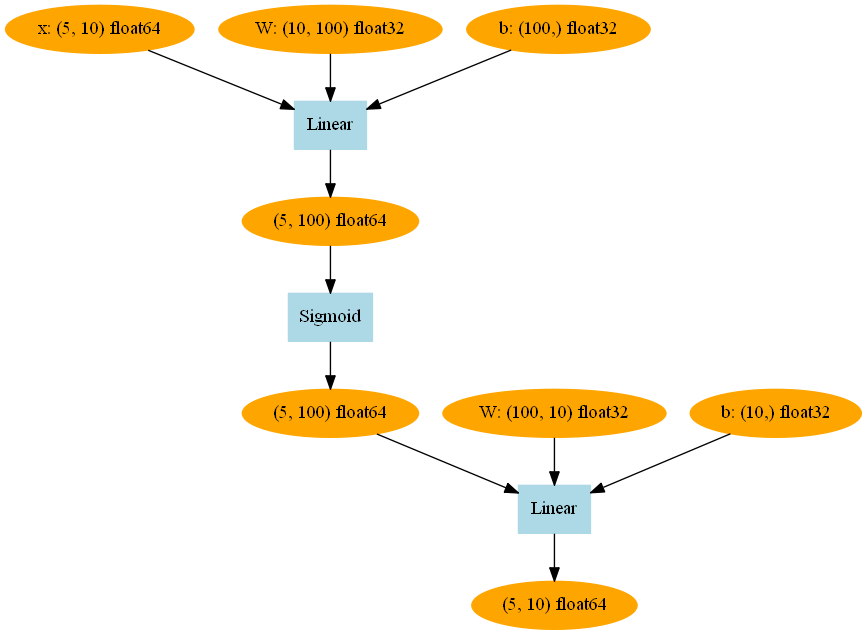

In [9]:
import numpy as np
from dezero import Model
import dezero.layers as L
import dezero.functions as F
from dezero.core import Variable

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y

x = Variable(np.random.randn(5, 10), name='x')
model = TwoLayerNet(100, 10)
model.plot(x)

In [12]:
import numpy as np
from dezero import Model
import dezero.layers as L
import dezero.functions as F

np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

# Hyperparameters
lr = 0.2
max_iter = 10000
hidden_size = 10

# Model definition
# 2층 신경망 모델 구현
class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x):
        y = F.sigmoid(self.l1(x))
        y = self.l2(y)
        return y


model = TwoLayerNet(hidden_size, 1)

for i in range(max_iter):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)

    model.cleargrads()                  # 모든 매개변수는 model을 통해 접근 가능하며 매개변수의 기울기 재설정도 model.cleargrads()로 가능.
    loss.backward()

    for p in model.params():
        p.data -= lr * p.grad.data
    if i % 1000 == 0:
        print(loss)

variable(0.8165178492839196)
variable(0.24990280802148895)
variable(0.24609876581126014)
variable(0.23721590814318072)
variable(0.20793216413350174)
variable(0.12311905720649353)
variable(0.07888166506355153)
variable(0.07655073683421634)
variable(0.07637803086238225)
variable(0.07618764131185568)


In [ ]:
# MLP Multiple-Layer_Perceptron 다중퍼셉트론 범용적인 완전연결계층 신경망
class MLP(Model):
    def __init__(self, fc_output_sizes, activation=F.sigmoid):      # fc_output_sizes는 신경망을 구성하는 연전연결계층들의 출력 크기를 튜플 또는 리스트로 지정.
        super().__init__()                                          # (10, 1)이면 2개의 Linear 계층을 만들고 ,첫번째 계층의 출력 크기는 10, 두번째 계층의 출력 크기는 1로 구성
        self.activation = activation                                # (10, 10, 1)을 건네면 Linear 계층이 총 3개
        self.layers = []

        for i, out_size in enumerate(fc_output_sizes):
            layer = L.Linear(out_size)
            setattr(self, 'l' + str(i), layer)
            self.layers.append(layer)

    def forward(self, x):
        for l in self.layers[:-1]:
            x = self.activation(l(x))
        return self.layers[-1](x)

model = MLP((10, 1))    # 2층
model = MLP((10, 20, 30, 40, 1))    # 5층